# PyDPF Example
In this 'VS Code 'Python Code file' a built-in example is selected, its model description is printed and results are selected and plotted.  
Selection is done by assigning variables

Print model description, note available results and timesteps  

In [1]:
import numpy as np
from ansys.dpf import post
from ansys.dpf import core as dpf
from ansys.dpf.core import examples

In [2]:
rst = examples.simple_bar
tf_idx = 0
dof_idx = 2

model = dpf.Model(rst)
print(model)

DPF Model
------------------------------
Static analysis
Unit system: MKS: m, kg, N, s, V, A, degC
Physics Type: Mecanic
Available results:
     -  displacement: Nodal Displacement
     -  element_nodal_forces: ElementalNodal Element nodal Forces
     -  elemental_volume: Elemental Volume
     -  stiffness_matrix_energy: Elemental Energy-stiffness matrix
     -  artificial_hourglass_energy: Elemental Hourglass Energy
     -  thermal_dissipation_energy: Elemental thermal dissipation energy
     -  kinetic_energy: Elemental Kinetic Energy
     -  co_energy: Elemental co-energy
     -  incremental_energy: Elemental incremental energy
     -  structural_temperature: ElementalNodal Temperature
------------------------------
DPF  Meshed Region: 
  3751 nodes 
  3000 elements 
  Unit: m 
  With solid (3D) elements
------------------------------
DPF  Time/Freq Support: 
  Number of sets: 1 
Cumulative     Time (s)       LoadStep       Substep         
1              1.000000       1           

In [3]:
timesteps = model.metadata.time_freq_support.time_frequencies
mesh = model.metadata.meshed_region
ugrid = mesh.grid

In [4]:
ugrid

UnstructuredGrid,Information
N Cells,3000
N Points,3751
X Bounds,"0.000e+00, 1.000e+00"
Y Bounds,"0.000e+00, 3.000e+00"
Z Bounds,"0.000e+00, 1.000e+00"
N Arrays,0


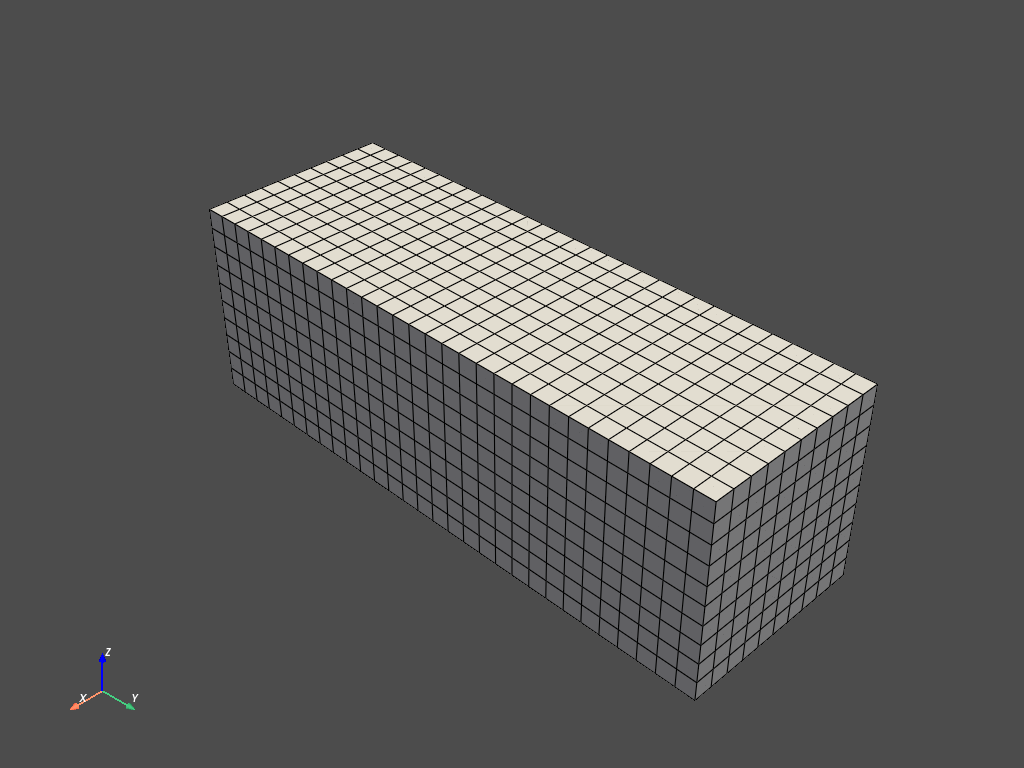

In [5]:
mesh.plot()

In [7]:
# 1st result in results set
res_idx = 0
# last available 'time' index
ts_idx = len(timesteps) - 1
# first component (if more than 1)
comp_idx = 0

result_info = model.metadata.result_info
res = result_info.available_results[res_idx]
print(res)

displacement
Operator name: "U"
Number of components: 3
Dimensionality: vector
Homogeneity: length
Units: m



DPF displacement(s)Fields Container
  with 1 field(s)
  defined on labels: time 

  with:
  - field 0 {time:  1} with Nodal location, 1 components and 3751 entities.



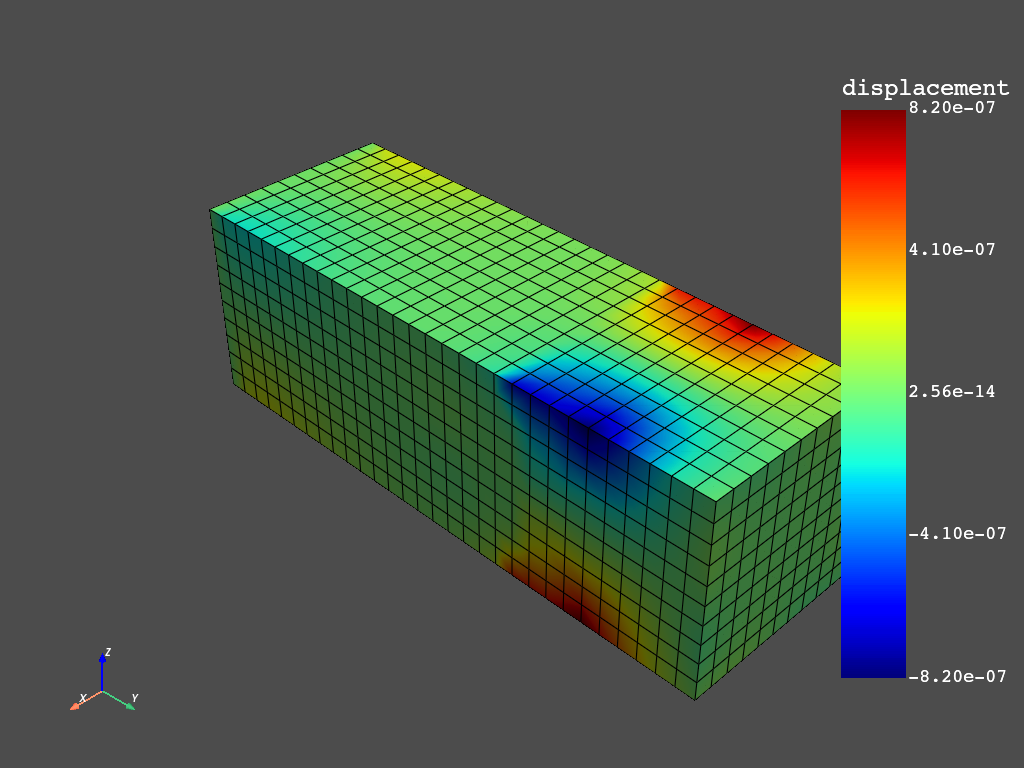

In [8]:

res_op = dpf.Operator(res.operator_name)
res_op.inputs.data_sources.connect(model.metadata.data_sources)
res_op.inputs.time_scoping([ts_idx + 1])
if res.n_components == 1:
    fields = res_op.outputs.fields_container()
elif res.n_components > 1:
    comp_sel = dpf.operators.logic.component_selector_fc()
    comp_sel.inputs.connect(res_op.outputs)
    comp_sel.inputs.component_number.connect(comp_idx)
    fields = comp_sel.outputs.fields_container()
print(fields)
f0 = fields[0]
mesh.plot(f0)

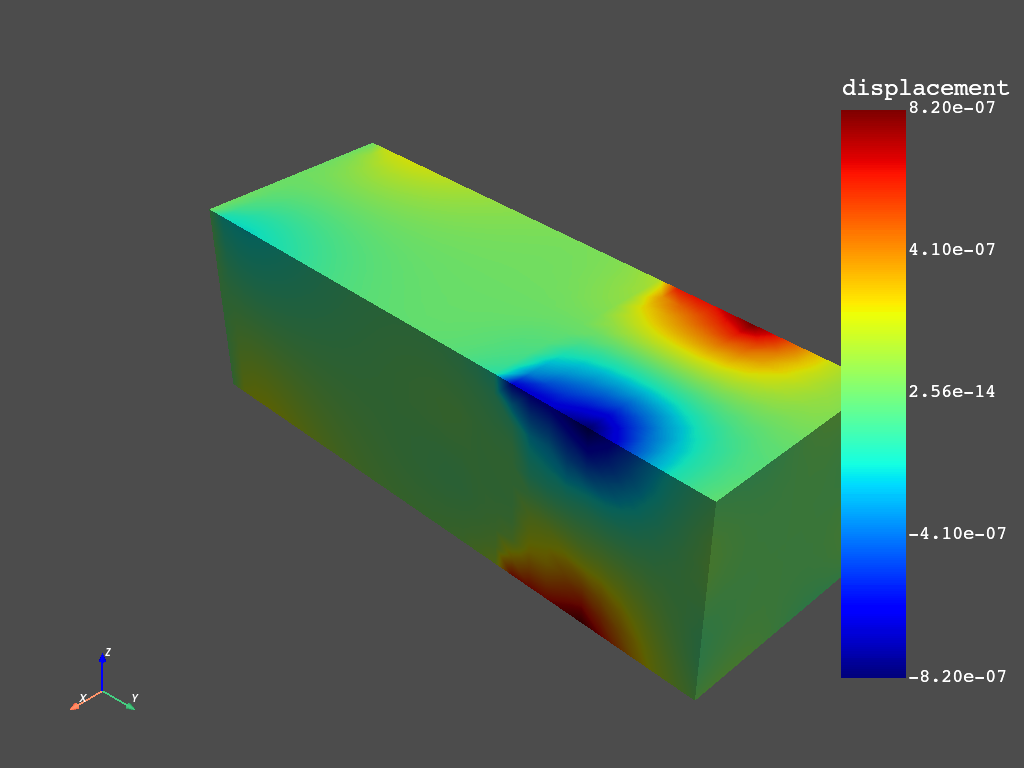

In [9]:
# %%
def get_grid_with_field(meshed_region, field):
    name = '_'.join(field.name.split("_")[:-1])
    location = field.location
    if location == dpf.locations.nodal:
        mesh_location = meshed_region.nodes
    elif location == dpf.locations.elemental:
        mesh_location = meshed_region.elements
    else:
        raise ValueError(
            "Only elemental or nodal location are supported for plotting."
        )
    overall_data = np.full(len(mesh_location), np.nan)
    ind, mask = mesh_location.map_scoping(field.scoping)
    overall_data[ind] = field.data[mask]

    grid = meshed_region.grid
    if location == dpf.locations.nodal:
        grid.point_data[name] = overall_data
    elif location == dpf.locations.elemental:
        grid.cell_data[name] = overall_data
    return grid


grid = get_grid_with_field(mesh, f0)
name = '_'.join(f0.name.split("_")[:-1])
grid.plot(scalars=name)


# %%